Programming Assignment: Numerical Optimization for Logistic Regression.
Name: QI QU

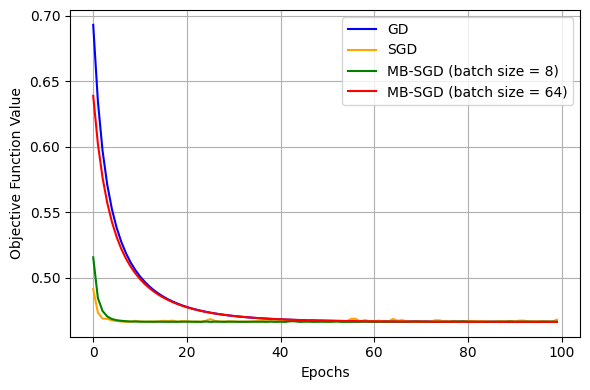

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.toarray()
y = y.reshape(-1, 1)

n = x.shape[0]
n_train = 640
rand_idx = np.random.permutation(n)
train_idx = rand_idx[:n_train]
test_idx = rand_idx[n_train:]

x_train = x[train_idx]
x_test = x[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

mu = np.mean(x_train, axis=0)
sig = np.std(x_train, axis=0)
x_train = (x_train - mu) / (sig + 1e-6)
x_test = (x_test - mu) / (sig + 1e-6)

x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

def objective(w, x, y, lam):
    yxw = y * np.dot(x, w)
    loss = np.mean(np.log(1 + np.exp(-yxw)))
    reg = lam / 2 * np.sum(w * w)
    return loss + reg

def gradient(w, x, y, lam):
    yxw = y * np.dot(x, w)
    vec = -y / (1 + np.exp(yxw))
    g = np.dot(x.T, vec) / x.shape[0] + lam * w
    return g

def grad_descent(x, y, lam, stepsize=0.5, max_iter=100, w=None):
    n, d = x.shape
    if w is None:
        w = np.zeros((d, 1))
    objvals = np.zeros(max_iter)
    for t in range(max_iter):
        objvals[t] = objective(w, x, y, lam)
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    return w, objvals

def stochastic_objective_gradient(w, xi, yi, lam):
    yxw = yi * np.dot(xi, w)
    loss = np.log(1 + np.exp(-yxw))
    reg = lam / 2 * np.sum(w * w)
    obj = loss + reg
    grad = (-yi * xi.T) / (1 + np.exp(yxw)) + lam * w
    return obj, grad

def sgd(x, y, lam, stepsize=0.01, max_epoch=100, w=None):
    n, d = x.shape
    if w is None:
        w = np.zeros((d, 1))
    objvals = np.zeros(max_epoch)
    for t in range(max_epoch):
        rand_idx = np.random.permutation(n)
        for i in range(n):
            xi = x[rand_idx[i], :].reshape(1, -1)
            yi = y[rand_idx[i]]
            _, g = stochastic_objective_gradient(w, xi, yi, lam)
            w -= stepsize * g
        objvals[t] = objective(w, x, y, lam)
    return w, objvals

def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    yxw = yi * np.dot(xi, w)
    loss = np.mean(np.log(1 + np.exp(-yxw)))
    reg = lam / 2 * np.sum(w * w)
    obj = loss + reg
    vec = -yi / (1 + np.exp(yxw))
    g = np.dot(xi.T, vec) / b + lam * w
    return obj, g

def mb_sgd(x, y, lam, b, stepsize=0.05, max_epoch=100, w=None):
    n, d = x.shape
    if w is None:
        w = np.zeros((d, 1))
    objvals = np.zeros(max_epoch)
    for t in range(max_epoch):
        rand_idx = np.random.permutation(n)
        x_shuffled = x[rand_idx]
        y_shuffled = y[rand_idx]
        for i in range(0, n, b):
            if i + b > n:
                continue
            xi = x_shuffled[i:i + b]
            yi = y_shuffled[i:i + b]
            _, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            w -= stepsize * g
        objvals[t] = objective(w, x, y, lam)
    return w, objvals

lam = 1e-6
_, objvals_gd = grad_descent(x_train, y_train, lam, stepsize=0.5)
_, objvals_sgd = sgd(x_train, y_train, lam, stepsize=0.01)
_, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b=8, stepsize=0.05)
_, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b=64, stepsize=0.05)

plt.figure(figsize=(6, 4))
plt.plot(objvals_gd, label='GD', color='blue')
plt.plot(objvals_sgd, label='SGD', color='orange')
plt.plot(objvals_mbsgd8, label='MB-SGD (batch size = 8)', color='green')
plt.plot(objvals_mbsgd64, label='MB-SGD (batch size = 64)', color='red')
plt.xlabel("Epochs")
plt.ylabel("Objective Function Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()